In [33]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

In [34]:
# Define your model (must match training)
class UNetGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU()
        )
        self.middle = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

In [35]:
def load_model(model_path, device):
    model = UNetGenerator().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

In [36]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    original_size = image.size

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    tensor = transform(image).unsqueeze(0)  # [1, 3, 256, 256]
    return tensor, original_size

In [37]:
def postprocess_image(tensor):
    tensor = tensor.squeeze(0).detach().cpu()
    tensor = (tensor * 0.5 + 0.5).clamp(0, 1)  # De-normalize
    image = transforms.ToPILImage()(tensor)
    return image


In [38]:
def cartoonize_image(model_path, input_image_path, output_path=None, device=None):
    """Main function to convert image to cartoon/anime style"""

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    try:
        # Load model
        print("Loading model...")
        model = load_model(model_path, device)

        # Preprocess image
        print("Preprocessing image...")
        input_tensor, original_size = preprocess_image(input_image_path)
        input_tensor = input_tensor.to(device)

        # Generate cartoon
        print("Generating cartoon image...")
        with torch.no_grad():
            output_tensor = model(input_tensor)

        # Postprocess
        print("Postprocessing...")
        cartoon_image = postprocess_image(output_tensor)
        cartoon_image = cartoon_image.resize(original_size, Image.LANCZOS)

        # Save if requested
        if output_path:
            cartoon_image.save(output_path)
            print(f"Cartoon image saved to: {output_path}")

        # Display results
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(Image.open(input_image_path))
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(cartoon_image)
        axes[1].set_title('Cartoon/Anime Style')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

        return cartoon_image

    except Exception as e:
        print(f"Error: {e}")
        print("If you're getting a model loading error, verify the model architecture and path.")
        return None

In [58]:
# Your paths
model_path = "generatorfinal100.pth"  # Path to your saved model
input_image_path = "./results.png"  # Your uploaded image
output_path = "catoon_convert.jpg"  #

Using device: cuda
Loading model...
Preprocessing image...
Generating cartoon image...
Postprocessing...
Cartoon image saved to: catoon_convert.jpg


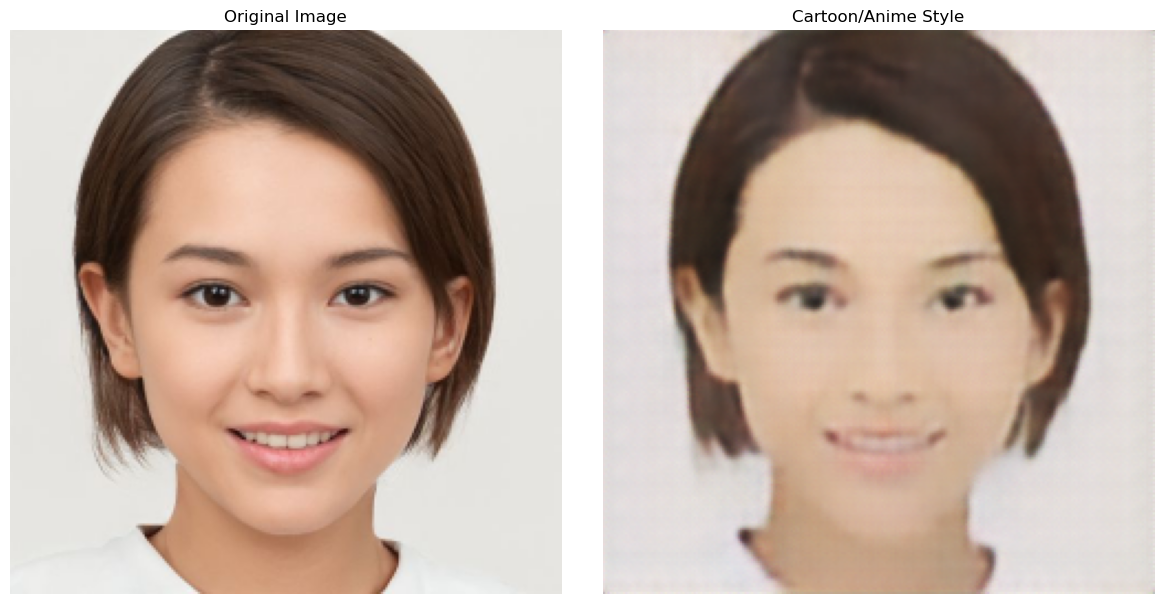

In [59]:

cartoon_image = cartoonize_image(
    model_path=model_path,
    input_image_path=input_image_path,
    output_path=output_path
)